In [63]:
#Importing the libraries I will use
import warnings
from glob import glob
import plotly.express as px
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [47]:
#creating a function to clean our datasets
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # droppinf features with high null counts
    df.drop(columns = ["floor", "expenses","Unnamed: 0"], inplace=True)
    
    #dropping high and low cardinality categorical variables
    df.drop(columns=["operation","property_type","currency","properati_url"], inplace = True)

    # dropping leaky columns
    df.drop(columns=[
        "price",
        "price_aprox_local_currency",
        "price_per_m2",
        "price_usd_per_m2"
    ], inplace=True)
    
    # dropping clumns with multicolinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

In [48]:
# importing data
files = glob("data/buenos-aires-c*.csv")
files

['data\\buenos-aires-c1.csv',
 'data\\buenos-aires-c2.csv',
 'data\\buenos-aires-c3.csv',
 'data\\buenos-aires-c4.csv',
 'data\\buenos-aires-c5.csv']

In [49]:
# data wrangling file by file
frames = [wrangle(file) for file in files]
type(frames[0])

pandas.core.frame.DataFrame

In [50]:
# combining the dataframes above
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [68]:
# to visualise the data on a map
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=1000,
    height=700,
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"]
)

fig.update_layout(mapbox_style = "open-street-map")
fig.show()

<AxesSubplot:>

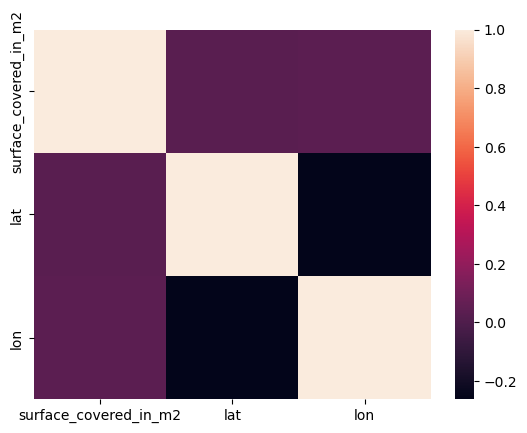

In [51]:
# identifying the correlations within the dataset to identify levels of multicolinearity
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

In [52]:
# split dataset into target vector and feature matrix
target = "price_aprox_usd"
features= ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
y_train = df[target]
X_train = df[features]

In [53]:
#build a baseline/ dummy model
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", round(y_mean))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132384
Baseline MAE: 44860.10834274134


In [54]:
# creating a pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
    )
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [55]:
# evaluate the model
# on trainig data
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 24207.10719033024


In [58]:
# evaluate on test data
X_test = pd.read_csv("data/buenos-aires-test.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

In [59]:
# Making a prediction
def make_prediction(area, lat, lon, neighborhood):
    data={
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [60]:
# example prediction
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

In [61]:
# an interactive slider to make predictions with input
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…